<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_16_CNNs_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import the Libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# To get summaries of the models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# CNN For MNIST Classification

## Import the Data and Normalize

In [3]:
# Import the data
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")

# Extract only the first 8 images
labels = data[:,0]
data = data[:,1:]

# Normalize 0-1
dataNorm = data/np.max(data)

# Reshape to 2d
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

# Check the sizes (number of images, dimension, height,width)
print(dataNorm.shape)
print(labels.shape)

(20000, 1, 28, 28)
(20000,)


## Split and Create DataLoader

In [4]:
# Step 1: Conver the data into Tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64 (integers)

# Step2: Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
# Check the size
train_loader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

## Create the Class for Model Training

In [8]:
def createTheMNISTNet(printtoggle=False):

    class mnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # Define the convolution layers
            self.conv1 = nn.Conv2d(1,10,kernel_size=5,stride=1,padding=1)
            # size: np.floor((28+2*1-5)/1) +1 = 13

            self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
            # size: np.floor((13+2*1-5)/1) +1 = 5

            # Compute the number of units in the FCLayer (number of outputs)
            expectSize = np.floor((5+2*0-1)/1)+1 # FC1 has no padding or kernel
            expectSize = 20*int(expectSize**2)

            # Fully-connected layer
            self.fc1 = nn.Linear(expectSize,50)

            # Output layer
            self.out = nn.Linear(50,10)

            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # Forward Pass
        def forward(self,x):
            
            # Printing the information for layers
            print(f"Input: {x.shape}") if self.print else None

            # Convolution -> maxpool -> relu
            # Maxpool window size is 2
            x = F.relu(F.max_pool2d(self.conv1(x),2))
            print(f"Layer conv1/pool1: {x.shape}") if self.print else None

            # Again Convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x),2))
            print(f"Layer conv2/pool2: {x.shape}") if self.print else None

            # Reshape the output from conv2/pool2 into linear layer
            # total number of elements/total # of data samples
            nUnits = x.shape.numel()/x.shape[0]
            # -1 is the batchsize (number of images)
            x = x.view(-1, int(nUnits))
            if self.print: print(f"Vectorize: {x.shape}")

            # Linear Layers
            x = F.relu(self.fc1(x))
            if self.print: print(f"Layer fc1: {x.shape}")
            x = self.out(x)
            if self.print: print(f"Layer Out: {x.shape}")

            return x

    # Create the model instance
    net = mnistNet(printtoggle)

    # define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [9]:
# Test the model with one batch to make sure it works
net, lossfun, optimizer = createTheMNISTNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer Out: torch.Size([32, 10])


In [10]:
# Check sizes of model outputs and target variables
print(yHat.shape)
print(y.shape)

torch.Size([32, 10])
torch.Size([32])


In [11]:
# Compute the loss (this is dummy)
loss = lossfun(yHat,y)
print(loss)

tensor(2.2987, grad_fn=<NllLossBackward0>)


In [13]:
# Summarize the model
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorize: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer Out: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


## Create a Function to Train the Model

In [14]:
def function2trainThemodel():

    # Define the number of epochs
    numepochs = 10

    # Create a new model instance: False by default to avoid printing
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Loop over the batches
        net.train()

        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss of a particular batch
            batchLoss.append(loss.item())

            # Compute the accuracy of the batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        # End of he batch loop

        # Get the values for training accuracy of a single epoch
        trainAcc.append(np.mean(batchAcc))

        # Train loss for single epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # Test Accuracy
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()
    # End the Epochs
    return trainAcc, testAcc, losses, net

In [15]:
# Run the mode
trainAcc, testAcc, losses, net = function2trainThemodel()

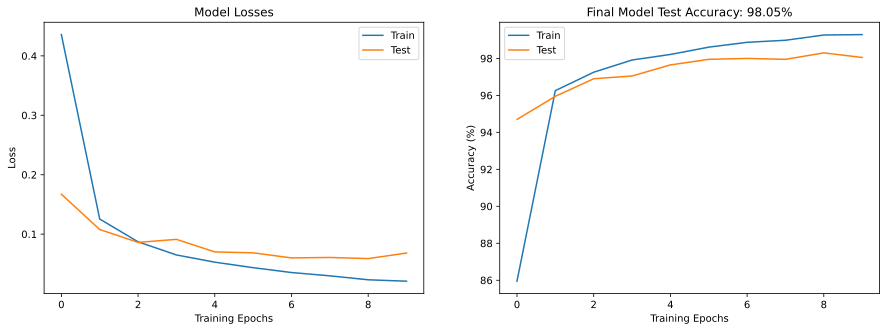

In [17]:
# Visualize it
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train", "Test"])
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()

# CNN on Shifted MNIST

## Shift the images

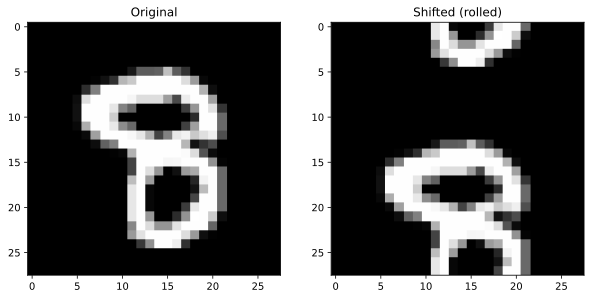

In [18]:
# Use the data from above: Start with DataLoader
tmp = test_loader.dataset.tensors[0][0,:]
# Now we don't need to reshape, its already in image form
# tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp,8,dims=1)

# now show them both
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(torch.squeeze(tmp), cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(torch.squeeze(tmpS), cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

In [19]:
# Shift all the training data
for i in range(train_loader.dataset.tensors[0].shape[0]):
  
    # get the image
    img = train_loader.dataset.tensors[0][i,:,:]
    
    # reshape and roll by 10 pixels
    randroll = np.random.randint(-10,11)
    img = torch.roll( img ,randroll,dims=1 )

    # re-vectorize and put back into the matrix
    train_loader.dataset.tensors[0][i,:,:] = img

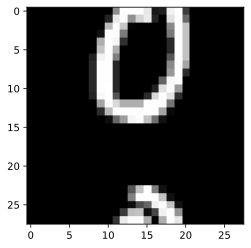

In [32]:
# Confirm with one image
plt.imshow(torch.squeeze(train_loader.dataset[0][0]), cmap='gray');

In [33]:
# Shift the test data
for i in range(test_loader.dataset.tensors[0].shape[0]):
  
  # get the image
  img = test_loader.dataset.tensors[0][i,:,:]
  
  # reshape and roll by 10 pixels
  randroll = np.random.randint(-10,11)
  img = torch.roll( img ,randroll,dims=1 )

  # re-vectorize and put back into the matrix
  test_loader.dataset.tensors[0][i,:,:] = img

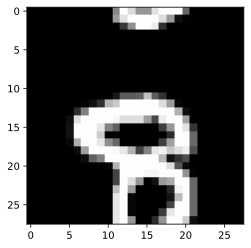

In [34]:
plt.imshow(torch.squeeze(test_loader.dataset[0][0]), cmap='gray');

In [36]:
# Train the model
trainAcc, testAcc, losses, net = function2trainThemodel()

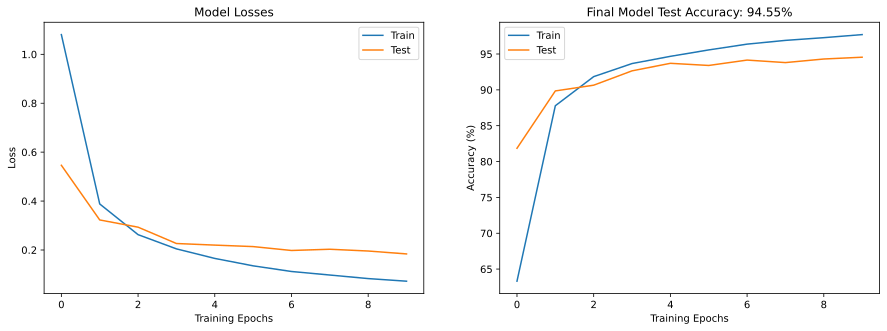

In [37]:
# Visualize it
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train", "Test"])
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()